In [4]:
import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
from sklearn import metrics
import torch

from models import ff
from utils import data_utils, data_loader, model_utils, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

%matplotlib inline

RUN_FOLDER = "../results/debug/"
NETWORK = "kcm/"
FOLD_MODEL = 4
device = torch.device("cpu")
NUM_WORKERS = 0
BATCH_SIZE = 512

In [5]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

kcm_dataloader = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)
atb_dataloader = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)

# Define embedded variables for nn models
kcm_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}
# Define embedded variables for nn models
atb_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}

In [6]:
# Load weights for a model
kcm_model = ff.FF(
    "FF",
    11,
    32,
    kcm_embed_dict,
    device
)
kcm_model.load_state_dict(torch.load(f"{RUN_FOLDER}kcm/models/FF_{FOLD_MODEL}.pt"))
kcm_model.eval()

atb_model = ff.FF(
    "FF",
    11,
    32,
    atb_embed_dict,
    device
)
atb_model.load_state_dict(torch.load(f"{RUN_FOLDER}atb/models/FF_{FOLD_MODEL}.pt"))
atb_model.eval()

FF(
  (loss_fn): MSELoss()
  (timeID_em): Embedding(1440, 24)
  (weekID_em): Embedding(7, 4)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=39, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [34]:
# Want to test models trained on one network against the other
all_results = []
labels, preds, avg_loss = model_utils.predict(kcm_model, kcm_dataloader)
print(avg_loss)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": "KCM",
    "Test Network": "KCM"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model, atb_dataloader)
print(avg_loss)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": "KCM",
    "Test Network": "ATB"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, atb_dataloader)
print(avg_loss)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": "ATB",
    "Test Network": "ATB"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, kcm_dataloader)
print(avg_loss)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": "ATB",
    "Test Network": "KCM"
}))

0.20637934853633244
0.29594117403030396
0.9663989543914795
0.9114548663298289


In [35]:
gen_df = pd.concat(all_results)
gen_df

,Labels,Preds,Train Network,Test Network
0,1963.000122,1678.389404,KCM,KCM
1,1761.000000,1735.625854,KCM,KCM
2,1769.000000,1578.296387,KCM,KCM
3,1694.000000,1574.637451,KCM,KCM
4,1798.000000,1847.650269,KCM,KCM
...,...,...,...,...
14981,186.203400,690.169434,ATB,KCM
14982,172.632172,704.074951,ATB,KCM
14983,141.719879,693.335815,ATB,KCM
14984,161.322784,706.846375,ATB,KCM


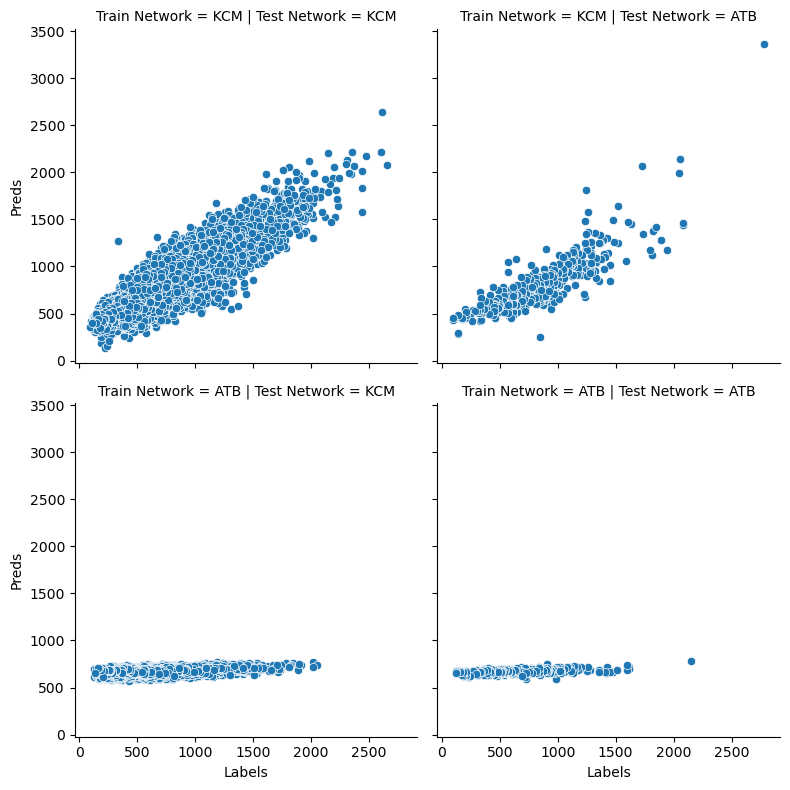

In [38]:
g = sns.FacetGrid(data=gen_df, col="Test Network", row="Train Network", height=4)
g.map(sns.scatterplot, "Labels", "Preds")
plt.savefig(f"../plots/model_generalization_preds.png", dpi=1800, bbox_inches='tight')